In [5]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import json
import string
from math import sqrt
%matplotlib inline
#import warnings
#warnings.simplefilter('error', RuntimeWarning)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
def plot(x, y, x_label="", y_label="", plot_type="scatter", color='blue'):
    
    if plot_type == "scatter":
        plt.scatter(x, y, color=color)
    
    elif plot_type == "plot":
        plt.plot(x, y, color=color)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    

In [7]:
def read_data(filename):
    df = pd.read_csv(filename)
    return df

In [8]:
def remove_punctuation(text):
    table = str.maketrans(dict.fromkeys(string.punctuation))
    stripped_text = text.translate(table)
    return stripped_text

In [9]:
def convert_to_numpy(dataframe, features, label):
    feature_matrix = dataframe[features].values
    feature_matrix = np.hstack((np.ones((feature_matrix.shape[0], 1)), feature_matrix))
    target_array = dataframe[label].values.reshape(-1, 1)
    return feature_matrix, target_array

In [10]:
def get_weighted_sums(x, params):
    w_sums = np.dot(x, params)
    return w_sums

In [11]:
def sigmoid(z):
    return np.divide(1, np.add(1, np.exp(np.multiply(-1, z))))

In [12]:
def calculate_hypothesis(x, params):
    predictions = sigmoid(get_weighted_sums(x, params))
    return predictions

In [13]:
def log_loss(x, y, params):
    epsilon = 1e-10    
    m = y.shape[0]
    hyp = calculate_hypothesis(x, params)
        
    eq_1 = np.multiply(y, np.log(hyp+epsilon))
    eq_2 = np.multiply(np.subtract(1, y), np.log(np.subtract(1, hyp)+epsilon))
    
    sum_of_eqs = np.sum(np.add(eq_1, eq_2))
    cost = (-1/m)*sum_of_eqs 
    
    return cost


In [53]:
def log_loss_regularized(x, y, params, lambda_=0):
    
    m = len(y)
    old_cost = log_loss(x,y,params)
    reg_term = (lambda_/2*m)*np.sum(np.square(params[1:]))
    regularized_cost = old_cost + reg_term

    return regularized_cost


In [88]:
def calculate_gradients_log_loss(x, y, params):
    hyp = calculate_hypothesis(x, params)
        
    #Calculating gradients
    diff = np.subtract(hyp, y)
    #gradients = np.multiply(1/len(y), np.dot(x.transpose(), diff))
    gradients = np.dot(x.transpose(), diff)
    
    return gradients

In [104]:
def calculate_gradients_log_loss_regularized(x, y, params, lambda_=0):
    m = len(y)
    hyp = calculate_hypothesis(x, params)
    diff = np.subtract(hyp, y)
    derivatives = np.dot(x.transpose(), diff)
    
    if lambda_ != 0:
        derivatives = np.multiply(derivatives, 1/m)
    
    gradients = derivatives.copy()
    gradients[1:] = np.subtract(derivatives[1:], np.multiply(params[1:], (lambda_/m)))

    return gradients

In [16]:
def log_likelihood(feature_matrix, sentiment, coefficients):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)
    return lp

In [17]:
def calculate_gradients_log_likelihood(x, y, params):
    hyp = calculate_hypothesis(x, params)
        
    #Calculating gradients
    diff = np.subtract(y, hyp)
    gradients = np.dot(x.transpose(), diff)

    return gradients

In [113]:
def gradient_descent(x, y, params, alpha=0.001, precision=0.000000001, tolerance=0.0001, iterations = 0, l2_penalty=0):
    
    #Total count of training exmaples and features
    m = y.shape[0]
    n = params.shape[0]
    
    #Creating a list for storing our cost function history
    cost_history = list()
    
    first_iteration = True
    its = 0
    iterate = False
    
    if iterations > 0:
        iterate = True
        
    print("-- Gradient Descent Started --\n")
    #print("Initial Parameters: \n", params)
    
    
    while True:
#       print("Iteration: ", its)
        gradients = calculate_gradients_log_loss_regularized(x, y, params, lambda_=l2_penalty)
        res = np.multiply(gradients, alpha)
        params = np.subtract(params, res)
        
        magnitude = np.sqrt(np.sum(np.square(gradients)))

        #Keeping track of the history of cost
        current_cost = log_loss_regularized(x, y, params, lambda_=l2_penalty)
        
        if magnitude <= tolerance:
            print("\nMagnitude condition satisfied - ending Gradient Descent")
            break
        
#         if not(first_iteration) and ((cost_history[-1] - current_cost) <= precision):
#             print("\nPrecision condition satisfied - ending Gradient Descent")
#             break

        if its <= 15 or (its <= 100 and its % 10 == 0) or (its <= 1000 and its % 100 == 0) \
        or (its <= 10000 and its % 1000 == 0) or its % 10000 == 0:
            print("iteration {}: log loss  of observed labels = {}".format(its, current_cost))
                
        if first_iteration:
            first_iteration = False
        
        cost_history.append(current_cost)
        
        its +=1
        
        if iterate and (its == iterations):
            print("\nIterations completed - ending Gradient Descent")
            break
            
    print("\n-- Gradient Descent Completed --\n")
    
    return params, cost_history, its
    

## Loading the data

In [19]:
products = read_data('amazon_baby_subset.csv')
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


Peeking into the dataset:
- The 'name' column indicates the name of the product.
- The 'review' column has the review of the product.
- The 'rating' column has rating of the product out of 5.
- The 'sentiment' column indicates whether it is a positive (+1) or a negative (-1) review.

## Cleaning the data

Instead of using all words in building bag-of-words features, but here we limit ourselves to 193 words (for simplicity). A compiled list of 193 most frequent words is in a JSON file (important_words.json).

In [20]:
with open('important_words.json', 'r') as file:
    important_words = json.load(file)
important_words = [str(word) for word in important_words]

Now, we have to do the following transformations on data:
- Remove the punctuations from the reviews.
- Add new features (bag-of-words).

In [21]:
products['review_cleaned'] = products['review'].astype(str).apply(remove_punctuation)

Adding bag of words features to our dataset (just most imporant words - not all!)

In [58]:
for word in important_words:
    products[word] = products['review_cleaned'].apply(lambda s : s.split().count(word))


In [23]:
products['sentiment'] = products['sentiment'].apply(lambda x : 0 if x == -1 else x)


In [19]:
# products.to_csv("products_final.csv", index=False)

Converting the dataframe into numpy arrays!

In [149]:
feature_matrix, sentiment = convert_to_numpy(products, important_words, 'sentiment')
params = np.zeros((feature_matrix.shape[1])).reshape(-1,1)

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

### L2 Penalty = 0

In [167]:
params_0_penalty, cost_hist, its = gradient_descent(feature_matrix, sentiment, params.copy(), alpha=1e-5, precision= 0.00001, tolerance=0.0001, iterations=501)

#print("Obtained Parameters: \n", new_params)
print("\nCost on the newly obtained parameters: ", cost_hist[-1])
print("\nTotal iterations taken: ", its)

-- Gradient Descent Started --

iteration 0: log loss  of observed labels = 6.6287714000289615
iteration 1: log loss  of observed labels = 6.382063691308432
iteration 2: log loss  of observed labels = 6.127656921423686
iteration 3: log loss  of observed labels = 5.865952430620754
iteration 4: log loss  of observed labels = 5.597487592068561
iteration 5: log loss  of observed labels = 5.323111152966313
iteration 6: log loss  of observed labels = 5.0441822161126435
iteration 7: log loss  of observed labels = 4.762242217582154
iteration 8: log loss  of observed labels = 4.478930495689722
iteration 9: log loss  of observed labels = 4.196583139501939
iteration 10: log loss  of observed labels = 3.91806884234726
iteration 11: log loss  of observed labels = 3.6463468498648015
iteration 12: log loss  of observed labels = 3.3846084502387224
iteration 13: log loss  of observed labels = 3.1365158058649745
iteration 14: log loss  of observed labels = 2.9051342640230846
iteration 15: log loss  of o

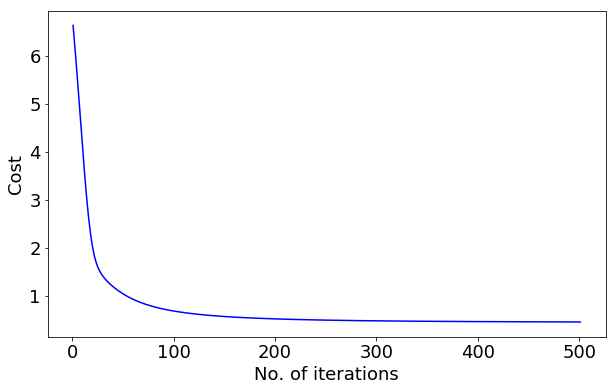

In [168]:
cost_hist = np.array(cost_hist)
iterations = np.arange(1, its+1)
plot(iterations, cost_hist, x_label="No. of iterations", y_label="Cost", plot_type="plot")

### L2 Penalty = 4

In [169]:
params_4_penalty, cost_hist, its = gradient_descent(feature_matrix, sentiment, params.copy(), alpha=1e-5, precision= 0.00001, tolerance=0.0001, iterations=501, l2_penalty=4)

#print("Obtained Parameters: \n", new_params)
print("\nCost on the newly obtained parameters: ", cost_hist[-1])
print("\nTotal iterations taken: ", its)

-- Gradient Descent Started --

iteration 0: log loss  of observed labels = 20485782.03290753
iteration 1: log loss  of observed labels = 20485765.198392034
iteration 2: log loss  of observed labels = 20485748.36388742
iteration 3: log loss  of observed labels = 20485731.52939372
iteration 4: log loss  of observed labels = 20485714.6949109
iteration 5: log loss  of observed labels = 20485697.86043899
iteration 6: log loss  of observed labels = 20485681.025977973
iteration 7: log loss  of observed labels = 20485664.191527862
iteration 8: log loss  of observed labels = 20485647.357088648
iteration 9: log loss  of observed labels = 20485630.522660334
iteration 10: log loss  of observed labels = 20485613.68824293
iteration 11: log loss  of observed labels = 20485596.85383641
iteration 12: log loss  of observed labels = 20485580.019440804
iteration 13: log loss  of observed labels = 20485563.185056098
iteration 14: log loss  of observed labels = 20485546.350682285
iteration 15: log loss  of

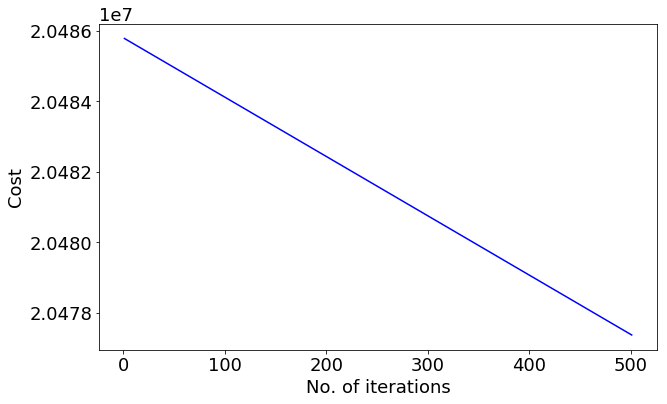

In [170]:
cost_hist = np.array(cost_hist)
iterations = np.arange(1, its+1)
plot(iterations, cost_hist, x_label="No. of iterations", y_label="Cost", plot_type="plot")

### L2 Penalty = 1000

In [171]:
params_1e3_penalty, cost_hist, its = gradient_descent(feature_matrix, sentiment, params.copy(), alpha=1e-5, precision= 0.00001, tolerance=0.0001, iterations=501, l2_penalty=1000)

#print("Obtained Parameters: \n", new_params)
print("\nCost on the newly obtained parameters: ", cost_hist[-1])
print("\nTotal iterations taken: ", its)

-- Gradient Descent Started --

iteration 0: log loss  of observed labels = 5121445720.516322
iteration 1: log loss  of observed labels = 5121443434.166286
iteration 2: log loss  of observed labels = 5121441147.817325
iteration 3: log loss  of observed labels = 5121438861.46944
iteration 4: log loss  of observed labels = 5121436575.122632
iteration 5: log loss  of observed labels = 5121434288.776899
iteration 6: log loss  of observed labels = 5121432002.432243
iteration 7: log loss  of observed labels = 5121429716.088664
iteration 8: log loss  of observed labels = 5121427429.74616
iteration 9: log loss  of observed labels = 5121425143.404731
iteration 10: log loss  of observed labels = 5121422857.064379
iteration 11: log loss  of observed labels = 5121420570.725102
iteration 12: log loss  of observed labels = 5121418284.386903
iteration 13: log loss  of observed labels = 5121415998.049779
iteration 14: log loss  of observed labels = 5121413711.713731
iteration 15: log loss  of observed

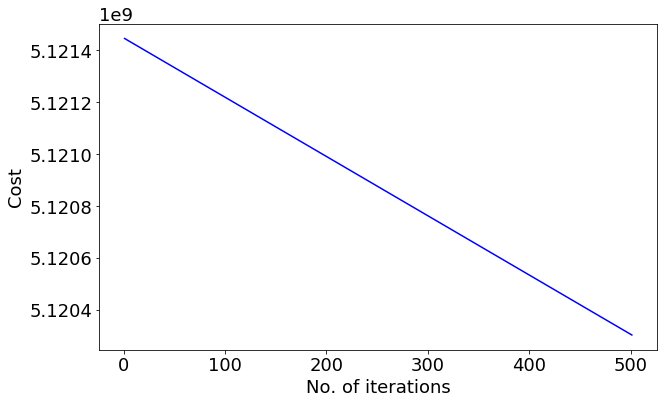

In [172]:
cost_hist = np.array(cost_hist)
iterations = np.arange(1, its+1)
plot(iterations, cost_hist, x_label="No. of iterations", y_label="Cost", plot_type="plot")

### L2 Penalty = 100000

In [173]:
params_1e5_penalty, cost_hist, its = gradient_descent(feature_matrix, sentiment, params.copy(), alpha=1e-5, precision= 0.00001, tolerance=0.0001, iterations=501, l2_penalty=1e5)

#print("Obtained Parameters: \n", new_params)
print("\nCost on the newly obtained parameters: ", cost_hist[-1])
print("\nTotal iterations taken: ", its)

-- Gradient Descent Started --

iteration 0: log loss  of observed labels = 512163678545.7017
iteration 1: log loss  of observed labels = 512182557788.2785
iteration 2: log loss  of observed labels = 512201437734.62396
iteration 3: log loss  of observed labels = 512220318384.76465
iteration 4: log loss  of observed labels = 512239199738.72687
iteration 5: log loss  of observed labels = 512258081796.5369
iteration 6: log loss  of observed labels = 512276964558.22125
iteration 7: log loss  of observed labels = 512295848023.8062
iteration 8: log loss  of observed labels = 512314732193.31836
iteration 9: log loss  of observed labels = 512333617066.7839
iteration 10: log loss  of observed labels = 512352502644.2292
iteration 11: log loss  of observed labels = 512371388925.68066
iteration 12: log loss  of observed labels = 512390275911.1648
iteration 13: log loss  of observed labels = 512409163600.7078
iteration 14: log loss  of observed labels = 512428051994.3363
iteration 15: log loss  of 

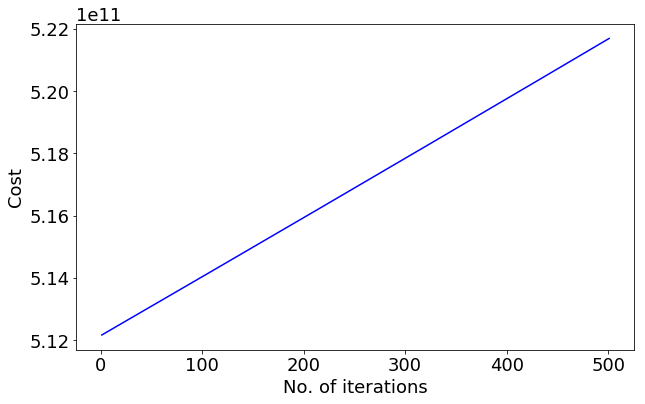

In [174]:
cost_hist = np.array(cost_hist)
iterations = np.arange(1, its+1)
plot(iterations, cost_hist, x_label="No. of iterations", y_label="Cost", plot_type="plot")

## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [175]:
table = pd.DataFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [176]:
add_coefficients_to_table(params_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(params_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(params_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(params_1e5_penalty, 'coefficients [L2=1e5]')

,word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=1e3],coefficients [L2=1e5]
0,(intercept),-0.172065,0.997532,0.997532,0.997531
1,baby,0.055137,0.999162,0.999256,1.008642
2,one,-0.010175,0.998988,0.999082,1.008467
3,great,0.879389,0.999670,0.999764,1.009153
4,love,1.241550,0.999868,0.999962,1.009351
5,use,-0.021430,0.999312,0.999406,1.008793
6,would,-0.345686,0.998941,0.999035,1.008420
7,like,-0.027356,0.999318,0.999412,1.008799
8,easy,1.133239,0.999842,0.999936,1.009326
9,little,0.562453,0.999687,0.999781,1.009169


In [177]:
sorted_words = table.sort_values(by="coefficients [L2=0]", ascending=False)
positive_words = sorted_words.iloc[:5][["word", "coefficients [L2=0]"]]
negative_words = sorted_words.iloc[-5:][["word", "coefficients [L2=0]"]]

In [178]:
positive_words

,word,coefficients [L2=0]
23,loves,1.663887
34,perfect,1.403927
4,love,1.241550
8,easy,1.133239
91,fits,1.064161


In [179]:
negative_words

,word,coefficients [L2=0]
172,broke,-0.657985
169,returned,-0.707105
97,money,-1.073000
114,return,-1.127726
106,disappointed,-1.419879


In [98]:
scores = np.dot(feature_matrix, new_params)
scores_pred = []
for score in scores:
    if score <= 0:
        scores_pred.append(-1)
    else:
        scores_pred.append(+1)

In [99]:
print("Positive Sentiments: ", len(scores[scores > 0]))
print("Negative Sentiments: ", len(scores[scores <= 0]))

Positive Sentiments:  22940
Negative Sentiments:  30132


In [100]:
products['scores_pred'] = scores_pred

In [101]:
correct = len(products[products['sentiment'] == products['scores_pred']][['sentiment','scores_pred']])
total = len(products['sentiment'])
print("Correct = {} | Incorrect = {} | Total = {} ".format(correct,total-correct, total))

Correct = 18060 | Incorrect = 35012 | Total = 53072 


In [102]:
accuracy = correct/total
print("Accuracy: ", accuracy)

Accuracy:  0.34029243292131445
